In [1]:
import os

import torch
import pandas as pd

from sample_and_train_utilities import (precompute_voxel_grids,
                                        SiteDataSet,
                                        FlexibleCNN3D,
                                        hyperparameter_search,
                                        analyse_hyperparameters)

This notebook follows the load_and_process.ipynb notebook.

By now, the file structure should look like:

```text
./
|
|- all_scpdb_entries.txt
|- excluded_scpdb_entries.txt
|- Data
    |
    |- scPDB
        |- 1a2b_1
            |- protein.mol2
            |- site.mol2
            |- ...(other possible files from scPDB)
        |- ...(all scPDB entries)
    |
    |- SCOPe
        |- 2_08.csv
        |- ...(possibly other SCOPe versions)
    |
    |- Pages
        |- 1a2b_1.txt
        |- ...(all the source codes of scPDB web pages)
    |
    |- Folds
        |- 1.csv
        |- ...(other folds)
        |- test.csv
    |
    |- Atoms
        |- 1a2b_1.csv
        |- ...(csvs with atom coords and props)
```

By the end of this notebook, the file structure will look like:

```text
./
|
|- all_scpdb_entries.txt
|- excluded_scpdb_entries.txt
|- Data
    |
    |- scPDB
        |- 1a2b_1
            |- protein.mol2
            |- site.mol2
            |- ...(other possible files from scPDB)
        |- ...(all scPDB entries)
    |
    |- SCOPe
        |- 2_08.csv
        |- ...(possibly other SCOPe versions)
    |
    |- Pages
        |- 1a2b_1.txt
        |- ...(all the source codes of scPDB web pages)
    |
    |- Folds
        |- 1.csv
        |- ...(other folds)
        |- test.csv
    |
    |- Atoms
        |- 1a2b_1.csv
        |- ...(csvs with atom coords and props)
    |
    |- Voxels
        |- 1
            |- 1a2b_1
                |- atoms_grid.npy
                |- occupancy.npy
                |- site_center.npy
            |- ... (other voxelized entries with voxel size 1)
        |
        |- 2
            |- 1a2b_1
                |- atoms_grid.npy
                |- occupancy.npy
                |- site_center.npy
            |- ... (other voxelized entries with voxel size 2)
    |
    |- CV
        |- pilot (folder for hyperparameter search)
            |- bs_128_do_0_cs_1
                |- train_loss.txt
                |- test_loss.txt
                |- true_labels.npy
                |- predictions.npy
            |- ... (other hyperparameter combinations)
```

In [2]:
# Default dirs and paths

SCPDB_DIR = 'Data/scPDB'
SCOPE_DIR = 'Data/SCOPe'
SCOPE_VERSION = '2.08'
PAGES_DIR = 'Data/Pages'
FOLDS_DIR = 'Data/Folds'
ATOMS_DIR = 'Data/Atoms'
VOXELS_DIR = 'Data/Voxels'
MAIN_CSV = 'Data/database.csv'
CV_LOGS = 'Data/CV'  # folder to store Cross-Validation logs
PILOT_DIR = 'Data/CV/pilot'  # folder to store hyperparameters serach logs

# Voxelization

Voxelization is computationally heavy, so I will only apply it to the chosen entries per fold, not for all 16000.

    IMPORTANT: the process may take a couple of hours and aroun 15 Gb of files will be generated

In [3]:
folds = sorted(os.listdir(FOLDS_DIR))
for fold in folds:
    main_entries = pd.read_csv(os.path.join(FOLDS_DIR, fold))['Main'].to_list()

    print(f'\nFold: {fold}\n')
    precompute_voxel_grids(list_of_entries=main_entries,
                        database_path = MAIN_CSV,
                        atoms_dir = ATOMS_DIR,
                        voxels_dir = VOXELS_DIR,
                        voxel_size = 1,
                        exist_ok = True)
    precompute_voxel_grids(list_of_entries=main_entries,
                        database_path = MAIN_CSV,
                        atoms_dir = ATOMS_DIR,
                        voxels_dir = VOXELS_DIR,
                        voxel_size = 2,
                        exist_ok = True)


Fold: 0.csv

Voxelization
Number of entries: 352, voxel_size: 1
Expected size of generated files: 1.0 Gb


100%|██████████| 352/352 [00:00<00:00, 65125.50it/s]

True size of generated files: 0 b
Entries skipped as existing: 352


Voxelization
Number of entries: 352, voxel_size: 2
Expected size of generated files: 132.0 Mb


100%|██████████| 352/352 [00:00<00:00, 71254.59it/s]


True size of generated files: 0 b
Entries skipped as existing: 352

Fold: 1.csv

Voxelization
Number of entries: 352, voxel_size: 1
Expected size of generated files: 1.0 Gb


100%|██████████| 352/352 [00:00<00:00, 72700.17it/s]

True size of generated files: 0 b
Entries skipped as existing: 352


Voxelization
Number of entries: 352, voxel_size: 2
Expected size of generated files: 132.0 Mb


100%|██████████| 352/352 [00:00<00:00, 75461.03it/s]

True size of generated files: 0 b
Entries skipped as existing: 352

Fold: 2.csv



Voxelization
Number of entries: 352, voxel_size: 1
Expected size of generated files: 1.0 Gb


100%|██████████| 352/352 [00:00<00:00, 80313.06it/s]

True size of generated files: 0 b
Entries skipped as existing: 352


Voxelization
Number of entries: 352, voxel_size: 2
Expected size of generated files: 132.0 Mb


100%|██████████| 352/352 [00:00<00:00, 77590.66it/s]

True size of generated files: 0 b
Entries skipped as existing: 352

Fold: 3.csv



Voxelization
Number of entries: 352, voxel_size: 1
Expected size of generated files: 1.0 Gb


100%|██████████| 352/352 [00:00<00:00, 81803.80it/s]

True size of generated files: 0 b
Entries skipped as existing: 352


Voxelization
Number of entries: 352, voxel_size: 2
Expected size of generated files: 132.0 Mb


100%|██████████| 352/352 [00:00<00:00, 81294.81it/s]

True size of generated files: 0 b
Entries skipped as existing: 352

Fold: 4.csv



Voxelization
Number of entries: 352, voxel_size: 1
Expected size of generated files: 1.0 Gb


100%|██████████| 352/352 [00:00<00:00, 88158.78it/s]

True size of generated files: 0 b
Entries skipped as existing: 352


Voxelization
Number of entries: 352, voxel_size: 2
Expected size of generated files: 132.0 Mb


100%|██████████| 352/352 [00:00<00:00, 80933.83it/s]

True size of generated files: 0 b
Entries skipped as existing: 352

Fold: 5.csv



Voxelization
Number of entries: 352, voxel_size: 1
Expected size of generated files: 1.0 Gb


100%|██████████| 352/352 [00:00<00:00, 89095.11it/s]

True size of generated files: 0 b
Entries skipped as existing: 352


Voxelization
Number of entries: 352, voxel_size: 2
Expected size of generated files: 132.0 Mb


100%|██████████| 352/352 [00:00<00:00, 77314.36it/s]

True size of generated files: 0 b
Entries skipped as existing: 352

Fold: 6.csv



Voxelization
Number of entries: 352, voxel_size: 1
Expected size of generated files: 1.0 Gb


100%|██████████| 352/352 [00:00<00:00, 79474.35it/s]

True size of generated files: 0 b
Entries skipped as existing: 352


Voxelization
Number of entries: 352, voxel_size: 2
Expected size of generated files: 132.0 Mb


100%|██████████| 352/352 [00:00<00:00, 90810.37it/s]

True size of generated files: 0 b
Entries skipped as existing: 352

Fold: 7.csv



Voxelization
Number of entries: 351, voxel_size: 1
Expected size of generated files: 1.0 Gb


100%|██████████| 351/351 [00:00<00:00, 82411.59it/s]

True size of generated files: 0 b
Entries skipped as existing: 351


Voxelization
Number of entries: 351, voxel_size: 2
Expected size of generated files: 132.0 Mb


100%|██████████| 351/351 [00:00<00:00, 87381.33it/s]

True size of generated files: 0 b
Entries skipped as existing: 351

Fold: 8.csv



Voxelization
Number of entries: 351, voxel_size: 1
Expected size of generated files: 1.0 Gb


100%|██████████| 351/351 [00:00<00:00, 82689.32it/s]

True size of generated files: 0 b
Entries skipped as existing: 351


Voxelization
Number of entries: 351, voxel_size: 2
Expected size of generated files: 132.0 Mb


100%|██████████| 351/351 [00:00<00:00, 87955.59it/s]

True size of generated files: 0 b
Entries skipped as existing: 351

Fold: 9.csv



Voxelization
Number of entries: 351, voxel_size: 1
Expected size of generated files: 1.0 Gb


100%|██████████| 351/351 [00:00<00:00, 73691.10it/s]

True size of generated files: 0 b
Entries skipped as existing: 351


Voxelization
Number of entries: 351, voxel_size: 2
Expected size of generated files: 132.0 Mb


100%|██████████| 351/351 [00:00<00:00, 69192.12it/s]

True size of generated files: 0 b
Entries skipped as existing: 351

Fold: test.csv



Voxelization
Number of entries: 1172, voxel_size: 1
Expected size of generated files: 3.0 Gb


100%|██████████| 1172/1172 [00:00<00:00, 103698.51it/s]

True size of generated files: 0 b
Entries skipped as existing: 1172


Voxelization
Number of entries: 1172, voxel_size: 2
Expected size of generated files: 440.0 Mb


100%|██████████| 1172/1172 [00:00<00:00, 99532.77it/s]

True size of generated files: 0 b
Entries skipped as existing: 1172


# Pilot run for hyperparameters search

Now, when all entries are stored as voxel grids with 8 channels, we can try a pilot run to find the appropriate hyperparameters

Notes:
- Due to computational infeasiblity of the project, I have decided to do a 5-fold CV, so folds will be merged pair-wise
- Pilot run only checks one fold (namely: fold 0 + fold 1 as test set)
- The number of hyperparameters checked is not large, but even with reductions of samples x2, the computation was barely possible on my device
- The patience for early stopping is set to 5.
- Will be checked:
    - dropouts 0, 0.1 and 0.25
    - batch sizes: 128 and 256
    - channels: 1 and 2 (it means that the actual number of channels will be x1 or x2, the exact model architecture can be found below)

All the runs will be sored to the PILOT_DIR

    IMPORTANT: the total computation time on my device (12-core CPU) was more than 35 hours.

### Model:

- Model architecture is based on DeepSite model. But provided that I use less training samples, I expect that the best hyperparameters might be different from though mentioned in DeepSite. 

In [4]:
class FlexibleCNN3D(torch.nn.Module):

    def __init__(self, dropout: float = 0.25, channel_size: int | float = 2):
        """
        This Model will only be used for hyperparameter search during the pilot run

        Dropout will be used as it is after convolution layers and with a factor of 2 between dense layers.

        Channel size will be used with a factor of 16.

        Args:
            dropout (float, optional): dropout. Defaults to 0.25.
            channel_size (int | float, optional): relative channel size. Defaults to 2.
        """

        # Check the input
        assert isinstance(dropout, float | int), f'dropout must be float or int, not {type(dropout)}'
        assert 0 <= dropout, f'dropout must be at least 0, not {dropout}'
        assert isinstance(channel_size, float | int), f'channel_size must be int or float, not {type(channel_size)}'
        assert 0 < channel_size, f'channel_size must be positive, not {channel_size}'
        
        super().__init__()

        # Store parameters
        self.dropout = dropout
        self.channel_size = channel_size


        self.model = torch.nn.Sequential(
            torch.nn.Conv3d(8, int(16 * channel_size), kernel_size=8, padding='same'),
            torch.nn.ELU(),
            torch.nn.Conv3d(int(16 * channel_size), int(16 * (channel_size + 1)), kernel_size=4, padding='same'),
            torch.nn.ELU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Dropout3d(dropout),
            torch.nn.Conv3d(int(16 * (channel_size + 1)), int(16 * (channel_size + 2)), kernel_size=4, padding='same'),
            torch.nn.ELU(),
            torch.nn.Conv3d(int(16 * (channel_size + 2)), int(16 * (channel_size + 3)), kernel_size=4, padding='same'),
            torch.nn.ELU(),
            torch.nn.MaxPool3d(2),
            torch.nn.Dropout3d(dropout),
            torch.nn.Flatten(),
            torch.nn.Linear(int(64 * 16 * (channel_size + 3)), 128),
            torch.nn.ELU(),
            torch.nn.Dropout(dropout * 2),
            torch.nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.model(x)

In [5]:
example_model_1 = FlexibleCNN3D(channel_size=1)
print(f'Model with channel size x1 has {sum(p.numel() for p in example_model_1.parameters() if p.requires_grad)} parameters')
example_model_2 = FlexibleCNN3D(channel_size=2)
print(f'Model with channel size x2 has {sum(p.numel() for p in example_model_2.parameters() if p.requires_grad)} parameters')

Model with channel size x1 has 917921 parameters
Model with channel size x2 has 1409505 parameters


It might seem that the number of parameters is low, but apparently 3D convolution is not supported by accelation algorithms on my CPU, which takes loads of time.

### Search:

In [6]:
hyperparameter_search(train_folds=[0, 1, 2, 3, 4, 5, 6, 7],
                      test_folds=[8, 9],
                      batch_sizes=[128, 256],
                      dropouts=[0, 0.1, 0.25],
                      channels=[1, 2],
                      exist_ok=True,
                      max_epochs=100,
                      patience=5,
                      reduction_factor=2,
                      voxel_size=1,
                      folds_dir=FOLDS_DIR,
                      voxels_dir=VOXELS_DIR,
                      pilot_dir=PILOT_DIR)

Run: Batch Size: 128; Dropout: 0; Channel Size: 1 is already present.
Run: Batch Size: 128; Dropout: 0; Channel Size: 2 is already present.
Run: Batch Size: 128; Dropout: 0.1; Channel Size: 1 is already present.
Run: Batch Size: 128; Dropout: 0.1; Channel Size: 2 is already present.
Run: Batch Size: 128; Dropout: 0.25; Channel Size: 1 is already present.
Run: Batch Size: 128; Dropout: 0.25; Channel Size: 2 is already present.
Run: Batch Size: 256; Dropout: 0; Channel Size: 1 is already present.
Run: Batch Size: 256; Dropout: 0; Channel Size: 2 is already present.
Run: Batch Size: 256; Dropout: 0.1; Channel Size: 1 is already present.
Run: Batch Size: 256; Dropout: 0.1; Channel Size: 2 is already present.
Run: Batch Size: 256; Dropout: 0.25; Channel Size: 1 is already present.
Run: Batch Size: 256; Dropout: 0.25; Channel Size: 2 is already present.


### Analysis:

Every subplot shows the trainig and evaluation process of 1 combination of HP mentioned in the title.

Dashed lines indicate the epoch with lowest test loss and the best test loss itself.

The red cross of dashed lines is used for the overall best combination of HP.

According to the plots, the best found combination is:
- Batch Size = 128
- DropOut = 0
- Channels = 32

Which is somewhat expected. DeepSite used 256 batch and 0.25 dropout, but it also used around twice as much samples. The number of channels seems to be independent from the number of 

Thus, for the real cross-validation runs I will use 128 batches, 0 dropout and 32+ channels. The best epoch for the chosen combination of HPs was 8, but to account for possible variation in folds, I will set epochs to 12 with patience 3 for early stopping.

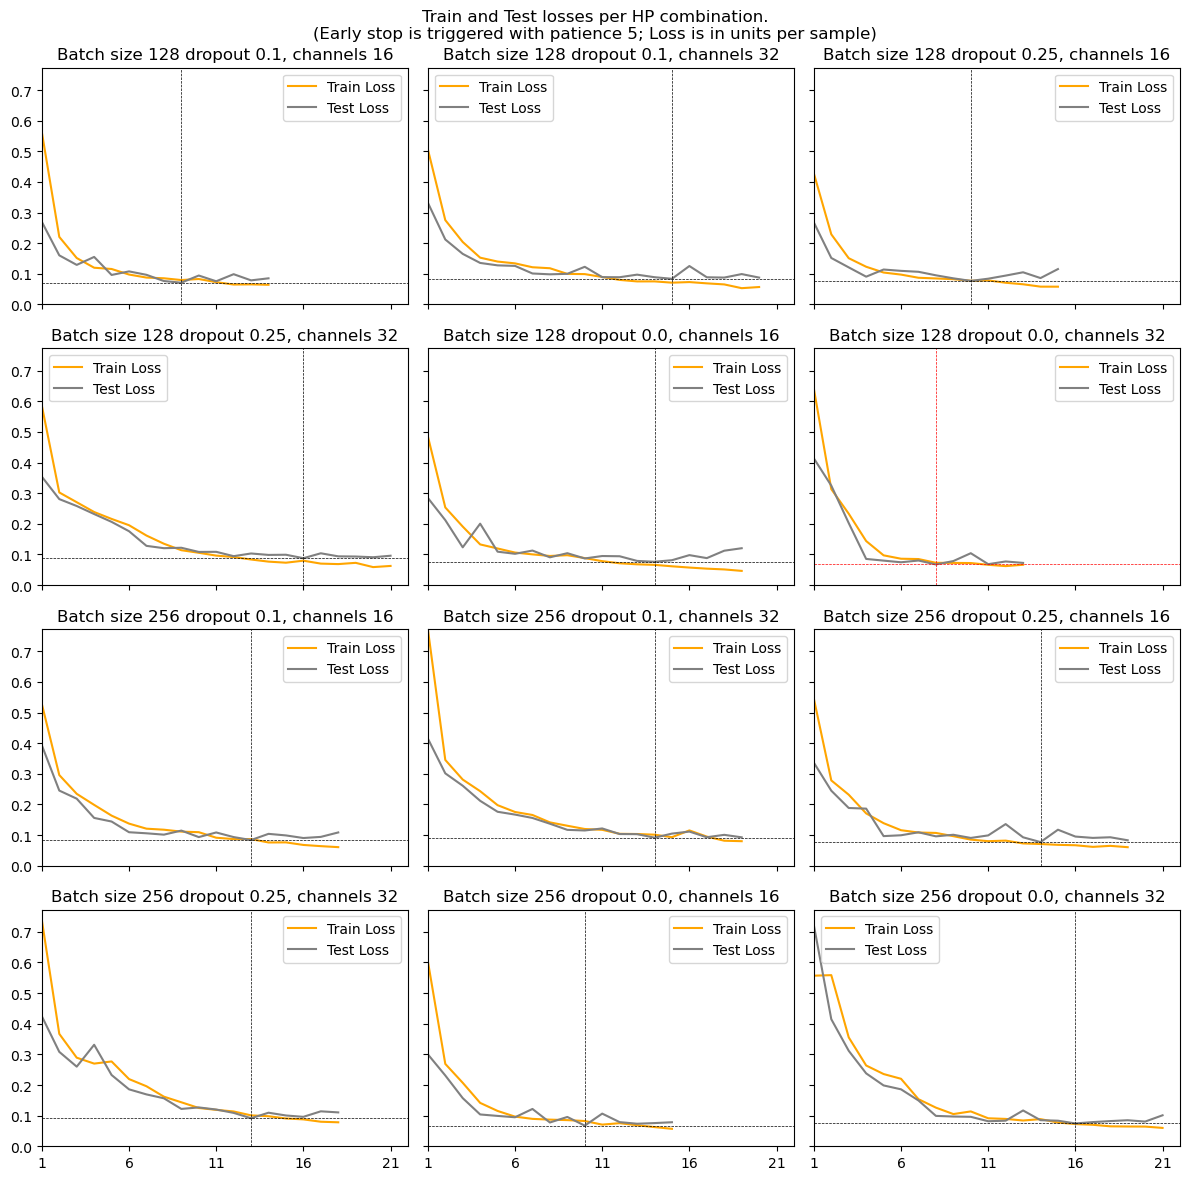

,batch_size,dropout,channels,train_losses,test_losses,true_labels,predictions,total_epochs,best_test_loss,best_train_loss,best_epoch,best_epoch_auc
0,128,0.10,1,"[0.5622382713132676, 0.22066364110309297, 0.15...","[0.26974280193256134, 0.16040688868533431, 0.1...","[[1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,...","[[0.888653101530062, 0.805977908301827, 0.9584...",14,0.071214,0.064326,9,0.995983
1,128,0.10,2,"[0.506701169927638, 0.27542032508065384, 0.204...","[0.3323639743873958, 0.21220924436944252, 0.16...","[[1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,...","[[0.6608690359213301, 0.7156319570363924, 0.92...",20,0.083902,0.053291,15,0.995250
2,128,0.25,1,"[0.4278844538608008, 0.2291061994654912, 0.151...","[0.2678984843465401, 0.15184184574347567, 0.12...","[[1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,...","[[0.8773212018779462, 0.8333733350082466, 0.95...",15,0.077036,0.058147,10,0.994916
3,128,0.25,2,"[0.585531515544303, 0.3023737651946022, 0.2705...","[0.3538261674310399, 0.2806967664329046, 0.258...","[[1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,...","[[0.737238072215556, 0.6931314920968418, 0.858...",21,0.087774,0.058708,16,0.994130
4,128,0.00,1,"[0.4857345810137684, 0.2534558876182505, 0.191...","[0.28458280656487994, 0.21202515942758718, 0.1...","[[1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,...","[[0.8954707573816065, 0.8857487132814522, 0.91...",19,0.076148,0.046373,14,0.995914
5,128,0.00,2,"[0.64125026626504, 0.3132948173141495, 0.23301...","[0.41363141082824884, 0.32466151453249875, 0.2...","[[1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,...","[[0.7486355957514529, 0.7079225434727243, 0.73...",13,0.067358,0.061961,8,0.996790
6,256,0.10,1,"[0.5277345183489699, 0.2958768899100061, 0.234...","[0.39295483185723096, 0.2451721186342314, 0.21...","[[1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,...","[[0.7786435179012353, 0.7469303323107285, 0.73...",18,0.083671,0.060523,13,0.994471
7,256,0.10,2,"[0.7728583565323315, 0.3451633049270937, 0.281...","[0.4150879638133653, 0.3013931388294969, 0.260...","[[1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,...","[[0.8896975606902039, 0.7100205002023837, 0.93...",19,0.091424,0.079953,14,0.994323
8,256,0.25,1,"[0.5453228301008154, 0.27839318316802586, 0.23...","[0.33624749921958474, 0.24480028391562503, 0.1...","[[1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,...","[[0.7351722673614082, 0.8389222687974144, 0.93...",19,0.077011,0.060373,14,0.994778
9,256,0.25,2,"[0.7382242568780306, 0.3669621337831468, 0.289...","[0.4243773657928302, 0.3081864332645263, 0.259...","[[1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1,...","[[0.5706448190933964, 0.5422954205866628, 0.54...",18,0.091536,0.078280,13,0.994226


In [7]:
analyse_hyperparameters(PILOT_DIR)